In [1]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import math
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from scipy.stats import pearsonr
#from dataset import Dataset, collate_fn
SEED = 2333

C:\Users\moham\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import os

import pickle


i = 0

feature_dir = 'tma//'
label_dir = 'tma_l//'



folders = os.listdir(feature_dir)
Atomic_wild = []
Atomic_wild2=[]
labels = []
sequence_names =[]
for i in range(len(folders)):
    print(i)
    Atomic_wild.append(pickle.load(open(feature_dir + folders[i] +  '//vectors.pkl'  , "rb")))
    #if len(Atomic_wild2[i])!= 2048 & len(Atomic_wild2[i])>25:
    #Atomic_wild.append(Atomic_wild2[i])
    labels.append(pickle.load(open(label_dir + folders[i] +  '//label.pkl'  , "rb"))[0][-1])
    sequence_names.append(folders[i])
    

#vectors = pickle.load(open(feature_dir + folders[i] +  '//vectors.pkl'  , "rb"))

#labels = pickle.load(open(label_dir + folders[i] +  '//label.pkl'  , "rb"))[0,-1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243


In [11]:
len(labels)

244

In [33]:
for i in range(len(Atomic_wild)):
    if len(Atomic_wild[i])== 2048 or len(Atomic_wild[i])<20:
        del Atomic_wild[i]
        del labels[i]
        del sequence_names[i]
    

In [69]:
k = []
for i in range(len(labels)):
    if labels[i]==0:
        k.append(1)

In [70]:
len(k)

6

In [12]:
Model_Path = './MTCGA/'
Result_Path = './RTCGA/'

In [13]:
WG = dict(zip(sequence_names, Atomic_wild))
zipped = list(zip(sequence_names, labels))
ds = pd.DataFrame(zipped, columns=['names', 'stability'])

In [14]:
def NodeM(name):
    return WG[name]

In [15]:
names = ds['names'].values.tolist()

In [16]:
from torch.utils.data.sampler import Sampler
  
class Dataset(Dataset):

    def __init__(self, dataframe):
        self.names = dataframe['names'].values.tolist()
        self.labels = dataframe['stability'].values.tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        
        sequence_name = self.names[index]
        label = self.labels[index]
        
        sequence_feature = NodeM(sequence_name)


        sample = {'sequence_feature': sequence_feature,\
                  'label': label, \
                  'sequence_name': sequence_name, \
                  }
        return sample
def collate_fn(batch):
    sequence_feature = []
    sequence_names = [] 
    labels=[]   
    for i in range(len(batch)):
        sequence_feature.append(batch[i]['sequence_feature'])
        sequence_feature=np.asarray(sequence_feature)
        sequence_names.append(batch[i]['sequence_name'])
        labels.append(batch[i]['label'])
        labels= np.asarray(labels)

    sequence_feature = torch.from_numpy(sequence_feature).float()
    labels= torch.from_numpy(labels)

    return sequence_feature, labels, sequence_names
def collate_MIL(batch):
	img = torch.cat([item[0] for item in batch], dim = 0)
	label = torch.LongTensor([item[1] for item in batch])
	return [img, label]


def initialize_weights(module):
	for m in module.modules():
		if isinstance(m, nn.Linear):
			nn.init.xavier_normal_(m.weight)
			m.bias.data.zero_()
		
		elif isinstance(m, nn.BatchNorm1d):
			nn.init.constant_(m.weight, 1)
			nn.init.constant_(m.bias, 0)

In [17]:
# Model parameters
NUMBER_EPOCHS = 100
LEARNING_RATE = 1E-5
WEIGHT_DECAY = 10E-6
BATCH_SIZE = 1

DENSE_DIM = 16
ATTENTION_HEADS = 4


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pdb
#from utils.utils import initialize_weights
import numpy as np


In [19]:
class Attn_Net_Gated(nn.Module):

    def __init__(self, L = 2560, D = 512, dropout = False, n_classes = 1):
        super(Attn_Net_Gated, self).__init__()
        self.attention_a = [
            nn.Linear(L, D),
            nn.Tanh()]
        
        self.attention_b = [nn.Linear(L, D),
                            nn.Sigmoid()]
        if dropout:
            self.attention_a.append(nn.Dropout(0.4))
            self.attention_b.append(nn.Dropout(0.4))

        self.attention_a = nn.Sequential(*self.attention_a)
        self.attention_b = nn.Sequential(*self.attention_b)
        
        self.attention_c = nn.Linear(D, n_classes)

    def forward(self, x):
        a = self.attention_a(x)
        b = self.attention_b(x)
        A = a.mul(b)
        A = self.attention_c(A)  # N x n_classes
        return A, x

In [20]:
class Attn_Net(nn.Module):

    def __init__(self, L = 1024, D = 512, dropout = False, n_classes = 1):
        super(Attn_Net, self).__init__()
        self.module = [
            nn.Linear(L, D),
            nn.Tanh()]

        if dropout:
            self.module.append(nn.Dropout(0.4))

        self.module.append(nn.Linear(D, n_classes))
        
        self.module = nn.Sequential(*self.module)
    
    def forward(self, x):
        return self.module(x), x # N x n_classes

In [23]:
import torch.nn.functional as F
class Model(nn.Module):
   # def __init__(self):
        #super(Model, self).__init__()
    def __init__(self, gate = True, size_arg = "small", dropout = False, n_classes = 6):
        super(Model, self).__init__()
        self.size_dict = {"small": [2560, 512, 256], "big": [1024, 1, 384]}
        size = self.size_dict[size_arg]

        fc = [nn.Linear(size[0], size[1]), nn.ReLU()]
        if dropout:
            fc.append(nn.Dropout(0.4))

        if gate:
            attention_net = Attn_Net_Gated(L = size[1], D = size[2], dropout = dropout, n_classes = 1)

        else:
            attention_net = Attn_Net(L = size[1], D = size[2], dropout = dropout, n_classes = 1)
        
        fc.append(attention_net)
        self.attention_net = nn.Sequential(*fc)
        self.classifier = nn.Linear(size[1], n_classes)

        initialize_weights(self)

        self.criterion = nn.CrossEntropyLoss()
        #self.criterion = nn.NLLLoss()

        self.optimizer = torch.optim.Adam(self.parameters(),lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    def forward(self, h, return_features=False, attention_only=False):
        A, h = self.attention_net(h) 
        #print(A)
        A = torch.transpose(A, 1, 0) 
        
        if attention_only:
            return A
        A_raw = A 
        A = F.softmax(A, dim=1) 
        M = torch.mm(A, h)
       # print(A)
        logits  = self.classifier(M) 
        Y_hat = torch.topk(logits, 1, dim = 1)[1]
        Y_prob = F.softmax(logits, dim = 1)

        results_dict = {}
        if return_features:
            results_dict.update({'features': M})
        
        return logits, Y_prob, Y_hat, A_raw, results_dict,M

In [24]:
class MIL_Attention_fc_surv(Model):
    def __init__(self, gate = True, size_arg = "small", dropout = False, n_classes = 6):
        super(MIL_Attention_fc_surv, self).__init__(gate = gate, size_arg = size_arg, dropout = dropout, n_classes = n_classes)

    def forward(self, h, return_features=False, attention_only=False):
        A, h = self.attention_net(h)  
        A = torch.transpose(A, 1, 0) 
        if attention_only:
            return A
        A_raw = A 
        A = F.softmax(A, dim=1) 
        M = torch.mm(A, h) 
        logits  = self.classifier(M) 
        Y_hat = torch.topk(logits, 1, dim = 1)[1]
        hazards = torch.sigmoid(logits)
        S = torch.cumprod(1 - hazards, dim=1)
        results_dict = {}
        if return_features:
            results_dict.update({'features': M})
        
        return hazards, S, Y_hat, A_raw, results_dict, M

In [25]:
def train_one_epoch(model, data_loader, epoch):

    epoch_loss_train = 0.0
    n_batches = 0
    for data in tqdm(data_loader):
        model.optimizer.zero_grad()
        sequence_feature, labels, sequence_names = data

        sequence_feature = torch.squeeze(sequence_feature)
       # labels = labels.unsqueeze(0)
        
        if torch.cuda.is_available():
            features = Variable(sequence_feature.cuda())
            y_true = Variable(labels.cuda())
        else:
            features = Variable(sequence_feature)
            y_true = Variable(labels)
            
        #logits, Y_prob, Y_hat, _, results_dict = model(data)
        #print(len(features))
        #if len(features)!= 2048 & len(features)>25:
        logits, y_pred, Y_hat, A, results_dict,M =  model(features)
        y_true = y_true
        y_pred = y_pred.mean(dim=0)
        Y_hat = torch.argmax(y_pred)
        #y_pred, dict_results = model(features)
        #Y_hat = Y_hat
        #print(logits)
        # calculate loss
        loss = model.criterion(logits, y_true.to(dtype=torch.long,non_blocking=False))
        #l2_lambda = 0.001
        #l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        #loss = loss + l2_lambda * l2_norm
        #print(loss)

        # backward gradient
        loss.backward()

        # update all parameters
        model.optimizer.step()

        epoch_loss_train += loss.item()
        n_batches += 1

    epoch_loss_train_avg = epoch_loss_train / n_batches
    #print(epoch_loss_train_avg)
    return epoch_loss_train_avg


In [26]:
def evaluate(model, data_loader):
    model.eval()

    epoch_loss = 0.0
    n_batches = 0
    valid_pred = []
    valid_true = []
    valid_name = []
    valid_score =[]
    valid_m = []

    for data in tqdm(data_loader):
        with torch.no_grad():
            sequence_feature, labels, sequence_names = data

            sequence_feature = torch.squeeze(sequence_feature)
            #labels = labels.unsqueeze(0)            
             
            if torch.cuda.is_available():
                features = Variable(sequence_feature.cuda())
               # labels = torch.squeeze(labels)

                y_true = Variable(labels.cuda())
            else:
                features = Variable(sequence_feature)
                y_true = Variable(labels)
            #if len(features)!= 2048 & len(features)>25:

                #y_pred, dict_results = model(features)
            logits, Y_prob, Y_hat, A, results_dict,M =  model(features)
            y_true = y_true
            Y_prob = Y_prob.mean(dim=0)
            Y_hat = torch.argmax(Y_prob)
        #y_pred, dict_results = model(features)
            #Y_hat = Y_hat
            #print(logits)

        # calculate loss
            #loss = model.criterion(Y_hat, y_true.long())
            #y_true = y_true

            loss = model.criterion(logits, y_true.to(dtype=torch.long,non_blocking=False))
            #l2_lambda = 0.001
            #l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            #loss = loss + l2_lambda * l2_norm
            #print(loss)

            y_pred = Y_hat.cpu().detach().numpy().tolist()
            y_true = y_true.cpu().detach().numpy().tolist()
            valid_pred.append(y_pred)
            valid_true.append(y_true)
            valid_name.extend(sequence_names)
            valid_score.append(A)
            valid_m.append(M)

            epoch_loss += loss.item()
            n_batches += 1
    epoch_loss_avg = epoch_loss / n_batches
    print(epoch_loss_avg)

    return epoch_loss_avg, valid_true, valid_pred, valid_name, valid_score,valid_m


In [71]:
def train(model, dk,dn,fold=0):
    train_loader = DataLoader(dataset=Dataset(ds) ,batch_size=1, shuffle=True, num_workers=0,collate_fn=collate_fn)
    valid_loader = DataLoader(dataset=Dataset(ds) ,batch_size=1, shuffle=True, num_workers=0,collate_fn=collate_fn)

    train_losses = []
    train_binary_acc = []

    valid_losses = []
    valid_binary_acc = []

    best_val_loss = 1000
    best_epoch = 0

    for epoch in range(NUMBER_EPOCHS):
        model.train()

        epoch_loss_train_avg = train_one_epoch(model, train_loader, epoch + 1)
        print(epoch_loss_train_avg)
        #print("========== Evaluate Train set ==========")
        #_, train_true, train_pred, _, _ = evaluate(model, train_loader)
        #print(len(train_pred), len(train_pred)
        #result_train,binpt,bintt = analysis(train_true, train_pred)
        #print("Train binary acc: ", result_train['binary_acc'])

        #train_binary_acc.append(result_train['binary_acc'])
        epoch_loss_valid_avg, valid_true, valid_pred, valid_name, valid_score,valid_m = evaluate(model, valid_loader)
        result_valid, binp,bint = analysis(valid_true, valid_pred)
        valid_binary_acc.append(result_valid['binary_acc'])
        if best_val_loss > epoch_loss_valid_avg:
            best_val_loss = epoch_loss_valid_avg
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(Model_Path, 'Fold' + str(fold) + '_best_score_model.pkl'))
            valid_detail_dataframe = pd.DataFrame({'names': valid_name, 'stability': valid_true, 'prediction': valid_pred})
            valid_detail_dataframe.sort_values(by=['names'], inplace=True)
            valid_detail_dataframe.to_csv(Result_Path + 'Fold' + str(fold) + "_valid_detail.csv", header=True, sep=',')
 
    #result_all = {
     #   'Train_binary_acc': train_binary_acc,
     #   'Valid_binary_acc': valid_binary_acc,}
    #result = pd.DataFrame(result_all)
    #print("Fold", str(fold), "Best epoch at", str(best_epoch))
    #result.to_csv('result.csv')

def analysis(y_true, y_pred):
    #print(len(y_pred))
    binary_pred = y_pred
    #print(binary_pred, y_true)
    binary_true= y_true

   
    binary_acc = metrics.accuracy_score(binary_true, binary_pred)
    result = {

        'binary_acc': binary_acc,

    }
    return result , binary_pred, binary_true

def cross_validation(all_dataframe,fold_number=10):
    print("split_seed: ", SEED)
    sequence_names = all_dataframe['names'].values
    sequence_labels = all_dataframe['stability'].values
    kfold = KFold(n_splits=fold_number, shuffle=True)
    fold = 0

    for train_index, valid_index in kfold.split(sequence_names, sequence_labels):
       
        train_dataframe = all_dataframe.iloc[train_index, :]
        valid_dataframe = all_dataframe.iloc[valid_index, :]
    
        model = Model()
        if torch.cuda.is_available():
            model.cuda()
        

        train(model, train_dataframe, valid_dataframe, fold + 1)
        fold += 1

In [72]:
cross_validation(ds,fold_number=5)

split_seed:  2333


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:02<00:00, 95.63it/s]


1.5488746471580912


100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 282.76it/s]


1.4686095025695738


100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:02<00:00, 109.22it/s]


1.4591054183537844


100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 492.32it/s]


1.4264470666158395


100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:02<00:00, 116.89it/s]


1.423199638724327


100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 497.80it/s]


1.4069668692154962


100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:02<00:00, 108.71it/s]


1.3981903373706537


100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 480.15it/s]


1.3811818895037058


100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:02<00:00, 105.36it/s]


1.3751820335622693


100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 445.54it/s]


1.3524155781650153


100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:02<00:00, 103.44it/s]


1.3527694569259394


 59%|██████████████████████████████████████████████▎                                | 143/244 [00:00<00:00, 459.67it/s]


KeyboardInterrupt: 

In [21]:
import pickle
import torch
import numpy as np
import torch.nn as nn
import pdb

import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Sampler, WeightedRandomSampler, RandomSampler, SequentialSampler, sampler
import torch.optim as optim
import pdb
import torch.nn.functional as F
import math
from itertools import islice
import collections
device=torch.device("cpu")

class SubsetSequentialSampler(Sampler):
	"""Samples elements sequentially from a given list of indices, without replacement.
	Arguments:
		indices (sequence): a sequence of indices
	"""
	def __init__(self, indices):
		self.indices = indices

	def __iter__(self):
		return iter(self.indices)

	def __len__(self):
		return len(self.indices)

In [63]:
a = torch.Tensor([[1]])

In [69]:
a.squeeze()

tensor(1.)

In [64]:
for model_name in sorted(os.listdir(Model_Path)):
        print(model_name)
        model = Model()
        if torch.cuda.is_available():
            model.cuda()
        model.load_state_dict(torch.load(Model_Path + model_name,map_location='cpu'))

        #epoch_loss_test_avg, test_true, test_pred, test_name = evaluate(model, train_loader)

Fold1_best_model.pkl
Fold2_best_model.pkl
Fold3_best_model.pkl
Fold4_best_model.pkl
Fold5_best_model.pkl


In [44]:
def test(test_dataframe):
    test_loader = DataLoader(dataset=Dataset(test_dataframe) ,batch_size=1, shuffle=False, num_workers=0,collate_fn=collate_fn)
    test_result = {}
    for model_name in sorted(os.listdir(Model_Path)):
        print(model_name)
        model_s = Model()
        if torch.cuda.is_available():
            model_s.cuda()
        model_s.load_state_dict(torch.load(Model_Path + model_name),strict=True)
        #model_s.load_state_dict(model_state, strict=True)
        model_s.eval()

    epoch_loss_valid_avg, valid_true, valid_pred, valid_name, valid_score,valid_m = evaluate(model_s, test_loader)
    #test_detail_dataframe = pd.DataFrame({'names': valid_name.cpu(), 'target': valid_true.cpu(), 'prediction': valid_pred.cpu(), 'Attention': valid_score.cpu()})

    return valid_m

In [42]:
def test(test_dataframe):
    test_loader = DataLoader(dataset=Dataset(ds) ,batch_size=1, shuffle=False, num_workers=0,collate_fn=collate_fn)
    test_result = {}
    for model_name in sorted(os.listdir(Model_Path)):
        print(model_name)
        model_s = Model()
        if torch.cuda.is_available():
            model_s.cuda()
        #model_s.load_state_dict(torch.load(Model_Path + model_name),strict=True)
        #model_s.load_state_dict(model_state, strict=True)
        model_state = torch.load(Model_Path + model_name)['state_dict']
        model_s.load_state_dict(model_state, strict=True)
        model_s.eval()


    epoch_loss_valid_avg, valid_true, valid_pred, valid_name, valid_score,valid_m = evaluate(model_s, test_loader)
    #test_detail_dataframe = pd.DataFrame({'names': valid_name.cpu(), 'target': valid_true.cpu(), 'prediction': valid_pred.cpu(), 'Attention': valid_score.cpu()})

    return valid_m

In [45]:
a = test(ds)

Fold0_best_score_model.pkl


100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 386.59it/s]

0.16572607752221033


In [301]:
len(a[1][0])

512

In [69]:
folders

['0096f71c-7777-417c-8d95-6fa1699879ec',
 '00be20a3-6ec8-44dd-afac-9085c6a03da9',
 '00ca6d3f-b495-4711-8ac3-d24175f5ee9f',
 '00f836a8-9b94-4413-95eb-fd127ee723b2',
 '01000de7-d0e8-4bb4-9918-4cbcd5bbfa3d',
 '0108fa63-6200-4896-8da9-0dbbd20998de',
 '011db747-84f4-4e3e-b446-1b667bef0ea9',
 '018aaaa8-78db-4341-8811-7356a871a2fe',
 '0222e12c-539f-4640-8007-fbd625fc0ea8',
 '024c0ec6-2e01-4640-a71c-6116e3a275ff',
 '029972c6-45c3-4a08-baf2-82a3b377fb71',
 '02b9de3a-c7ee-46ff-b0b7-e0561e6b3101',
 '0309db59-8d00-4c20-b816-015a3576f059',
 '039256d5-14c1-4057-b535-01416d2ba5ac',
 '0492d6eb-5192-45ca-949f-958e9f22c29d',
 '05042790-054b-43ea-a8bc-a8dd524c4627',
 '05792b42-0953-48ea-a4b1-3e9a1691677b',
 '0592845a-01d7-4d42-8149-72af28b83c53',
 '068e7a7f-7db9-4769-8052-33c03e1f7f32',
 '06a5cbd5-f9f4-466f-9f5a-a3fdea74f270',
 '07cee6c6-be65-47dd-b1d3-7a3311dec0a6',
 '07d54db2-b54b-4f87-a281-68f0de5328bb',
 '0834dfbb-1b2b-4125-a95b-d43a829c6fc7',
 '084893ca-b836-4824-a9b1-590980679155',
 '087647cd-4f1c-

In [45]:
k[0]

array([-12.183532  , -16.031633  ,  -8.247472  ,   4.726293  ,
        -9.30664   ,  -5.227593  ,  -3.7266526 ,  -5.4375567 ,
        -2.2070858 , -13.036091  ,  -7.0528045 ,  -0.68808854,
         0.39930555, -10.266589  , -10.2307005 ,   2.613756  ,
       -12.920837  ,  -6.549688  ,  -5.613616  ,  -7.8374443 ,
        -7.7921085 ,  -9.140434  ,  -9.385743  , -10.26526   ,
        -2.1868188 ,  -7.2497435 ,  -6.0480313 ,  -8.618247  ,
       -16.45893   , -18.336338  ,  -4.40285   , -18.357244  ,
       -12.589316  ,   1.3548671 , -21.331793  , -15.634724  ,
        -4.177356  ,  -6.0681257 , -16.525446  ,  -6.559504  ,
       -12.641933  ,  -0.88555914,  -7.1555767 , -17.017405  ,
        -3.9066794 ,  -3.381975  ,  -6.362362  , -11.2598915 ,
        -6.070004  , -13.951755  ,   0.8152772 ,   1.8666137 ,
        -7.7423277 ,  -8.795559  ,  -4.911399  , -13.958804  ,
        -9.649624  , -13.549354  ,  -7.519152  , -11.454564  ,
        -7.9854403 , -15.583977  ,  -7.3529687 , -13.84

In [368]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(kd)

PCA(n_components=2)

In [369]:
x=pca.transform(kd)


In [365]:
x

array([[ -6.17854008,   2.76613343],
       [-10.3378128 ,  -4.02213912],
       [ -1.71772588,   4.96465484],
       ...,
       [  6.47342608,  -3.41744608],
       [ -4.53532986,   5.41039624],
       [ 11.8884514 ,  -3.07450658]])

In [46]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D

In [304]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(k)
kd = scaler.transform(k)

In [153]:
k[0]

array([1.16838984e-01, 2.19050795e-01, 1.11680124e-02, 2.37817992e-03,
       1.01016319e+00, 7.20178723e-01, 2.90293574e-01, 3.70358765e-01,
       4.63254035e-01, 2.27242541e+00, 2.20242981e-02, 1.53948541e-03,
       8.50362889e-03, 1.84561033e-02, 7.02389181e-01, 1.10635364e+00,
       6.70111999e-02, 1.07606743e-02, 2.29817212e-01, 8.50365996e-01,
       9.37334727e-03, 4.60230112e-02, 1.01848096e-01, 2.40456741e-02,
       5.13535678e-01, 1.99340377e-02, 4.51223878e-03, 1.12211311e+00,
       2.34143376e-01, 3.11005171e-02, 1.48649490e+00, 1.01106152e-01,
       1.82239455e-04, 1.81789746e-05, 4.74794880e-02, 6.89537287e-01,
       5.14476001e-02, 4.10674870e-01, 7.24881738e-02, 1.60232335e-02,
       1.05521856e-02, 5.76476892e-03, 1.83124924e+00, 4.64908242e-01,
       3.17659885e-01, 1.84280241e+00, 7.18464613e-01, 5.00652492e-02,
       9.90054309e-02, 2.14104429e-02, 6.71101928e-01, 7.11523788e-03,
       2.99086384e-02, 8.59529376e-01, 3.23786110e-01, 1.19120057e-03,
      

In [71]:
f =pd.DataFrame(x_pca, columns=['a1','a2','a3','a4','a5','a6'])

In [133]:
pca_result = pca.fit_transform(k)
df = pd.DataFrame()

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.33103459 0.23903599 0.0635296  0.04168527 0.0370589  0.02238295]


In [65]:
tsne = TSNE(n_components=2, verbose =20, random_state=42, perplexity=100,n_iter=10000)
#tsne = TSNE(n_components=2, verbose =1, random_state=42)
# fit and transform
z = tsne.fit_transform(k)

C:\Users\moham\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\moham\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 243 nearest neighbors...
[t-SNE] Indexed 244 samples in 0.001s...
[t-SNE] Computed neighbors for 244 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 244 / 244
[t-SNE] Mean sigma: 3.330107
[t-SNE] Computed conditional probabilities in 0.013s
[t-SNE] Iteration 50: error = 50.5885277, gradient norm = 0.4299263 (50 iterations in 4.665s)
[t-SNE] Iteration 100: error = 48.8904305, gradient norm = 0.4899024 (50 iterations in 4.618s)
[t-SNE] Iteration 150: error = 50.1121597, gradient norm = 0.4925601 (50 iterations in 4.546s)
[t-SNE] Iteration 200: error = 52.8223877, gradient norm = 0.5058821 (50 iterations in 5.111s)
[t-SNE] Iteration 250: error = 49.7770500, gradient norm = 0.4780506 (50 iterations in 4.773s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.777050
[t-SNE] Iteration 300: error = 0.1556322, gradient norm = 0.0044803 (50 iterations in 4.004s)
[t-SNE] Iteration 350: error = 0.1452078, gradient norm = 0.0001532 

In [67]:
cps_d = pd.DataFrame(columns=['CP1', 'CP2', 'target'],
                       data=np.column_stack((z, 
                                            labels)))
# cast targets column to int
cps_d.loc[:, 'target'] = cps_d.target.astype(int)
cps_d.head()

,CP1,CP2,target
0,-3.440050,-5.316934,4
1,-3.323400,-4.087803,4
2,-4.438326,-4.405645,4
3,-4.033814,-3.043967,4
4,-1.953089,-3.470032,3


In [56]:
import seaborn as sns

C:\Users\moham\anaconda3\envs\pytorch\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


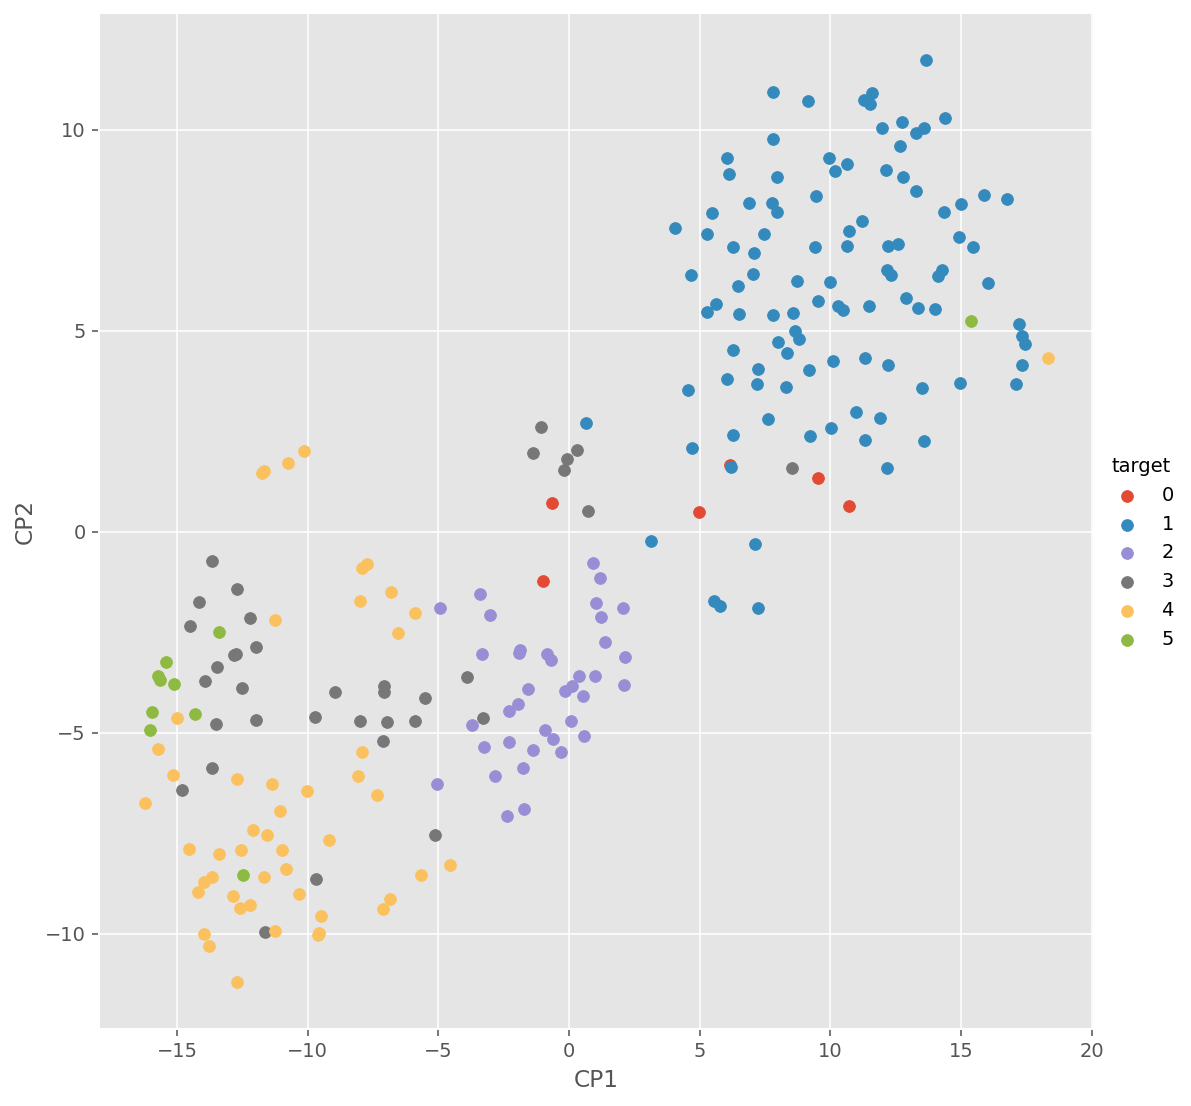

In [63]:
grid = sns.FacetGrid(cps_d, hue="target", size=8)
grid.map(plt.scatter, 'CP1', 'CP2').add_legend()

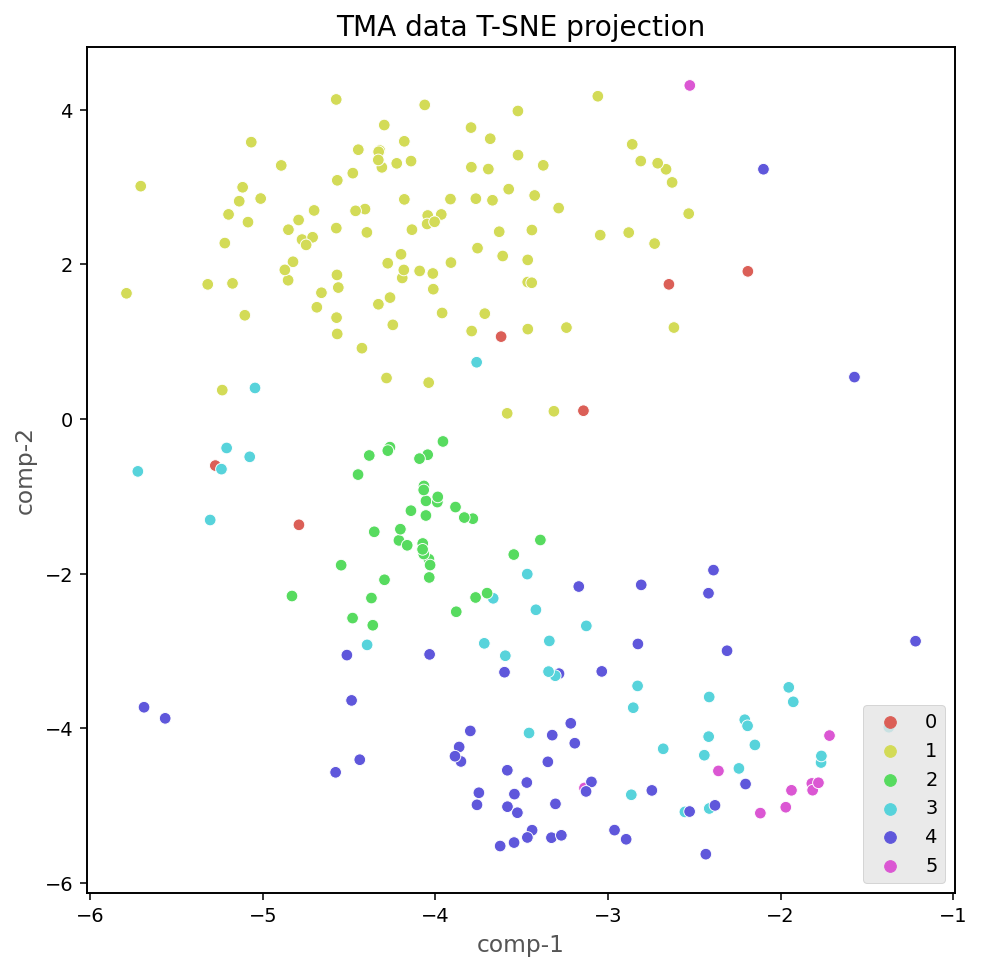

In [68]:
df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
#sns.set(rc={"figure.figsize":(8, 8)}) #width=8, height=4
fig = plt.gcf()
ax = fig.add_subplot()

      #setting up Y-axis label color to blue
plt.rcParams['axes.facecolor'] = 'white'
plt.style.use('ggplot')
ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black
ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
ax.spines['top'].set_color('black')   
ax.spines['right'].set_color('black')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('black')
# Change seaborn plot size
fig.set_size_inches(8, 8)

ax.set_facecolor('white')

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 140
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls",6),
                data=df).set(title="TMA data T-SNE projection") 


plt.legend(loc='lower right')
plt.savefig("tm_tsne.png",bbox_inches="tight",edgecolor='none',pad_inches=0.02,dpi=500)

In [85]:
e[0]

tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0

In [84]:
e = []
target_len = 100
for i in range(len(k)):
    e.append(F.pad(a[i], (target_len - a[i].size(1), 0)))


In [83]:
np.save('attnetion score.npy',k)

C:\Users\moham\anaconda3\envs\pytorch\lib\site-packages\numpy\lib\npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [64]:
test_images = a[0].detach ().cpu ().numpy ()

In [85]:
np.save('name.npy',folders)

In [47]:
v=[]
for i in range(len(a)):
    v.append(a[i].detach ().cpu ().numpy ())
k = []
for i in range(len(a)):
    k.append(v[i][0])

In [50]:
len(k[10])

512

In [303]:
k = []
for i in range(len(a)):
    k.append(v[i][0])

In [41]:
score_dir = 'st//'

for i in range(len(sequence_names)):
    os.makedirs(score_dir + sequence_names[i])
    with open(score_dir + sequence_names[i] + '//score.pkl', 'wb') as f:
        pickle.dump(k[i], f) 

In [231]:
len(Atomic_wild[6320])

311

In [40]:
len(k[210])

71

In [232]:
len(a[6320][0])

311

In [66]:
len(Atomic_wild[200])

7200

In [67]:
len(k[200])

7200

In [236]:
np.save('labels_pandas_binary',labels)